<!-- ![FOTO](./img/logo.jpeg)  -->
# ***Deep Vision para tareas de clasificación***
## ***By Noelia Otazo Rojo***

### Objetivos
**Evaluar y comparar** estrategias para la **clasificación de imágenes**, la solución deberá estar basada en el **aprendizaje profundo (Redes Neuronales Convolucionales CNNs)**.

### Contenidos
1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo.

### Fuente de datos
Enlace al dataset que voy a utilizar para llevar a cabo el siguiente proyecto:
[Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

## 0. Preparación del proyecto.
En esta sección añadimeros las sentencias de instalación y las importaciones de las librerías necesarias para el desarrollo del proyecto.

In [1]:
# Solo ejecuitar una vez
#!pip install opencv-python

A continuación será necesario importar las librerías.

In [2]:
# Numpy
import numpy as np
from numpy.random import seed

# OpenCV to process images
import cv2

# Necesario para la tranformación de las imagenes de tif a png
import pathlib
from PIL import Image

# Directory indexes
import os
from os import listdir

import shutil
import random
from pathlib import Path
from pprint import pprint
from collections import defaultdict

# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Pandas
import pandas as pd

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormaliz
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Ploteado del esquema gráfico del modelo
# from keras.utils.vis_utils import plot_model

## 1. Conjunto de datos.
En esta sección cargaremos el contenido del dataset para su posterior uso.

### 1.1 Carga del conjunto de datos.
De este modo tendremos ya almacenado en variables las ubicaciones de los ficheros de labels así como la ruta a la carpeta que contiene las imágenes.

In [3]:
# Data
test_data_path = 'histopathologic-cancer-detection/test'
train_data_path = 'histopathologic-cancer-detection/train'
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
validation_labels = pd.read_csv('histopathologic-cancer-detection/validation_labels.csv')

# Obtiene los nombres de clase únicos como una lista
class_names = train_labels['label'].unique().tolist()

# Asegúrate de que los nombres de clase sean strings si es necesario
class_names = [str(name) for name in class_names]
print(train_labels.head())
print(validation_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0


###  1.2 Distribución train / test 
A continuación generaremos un gráfico para comprobar la distribución del contenido de train/test, ya que venía ya distribuído desde Kaggle, por lo que no será necesrio hacer un nuevo split de los datos.

La carpeta train tiene 220025 elementos con proporción 0.79
La carpeta test tiene 57458 elementos con proporción 0.21


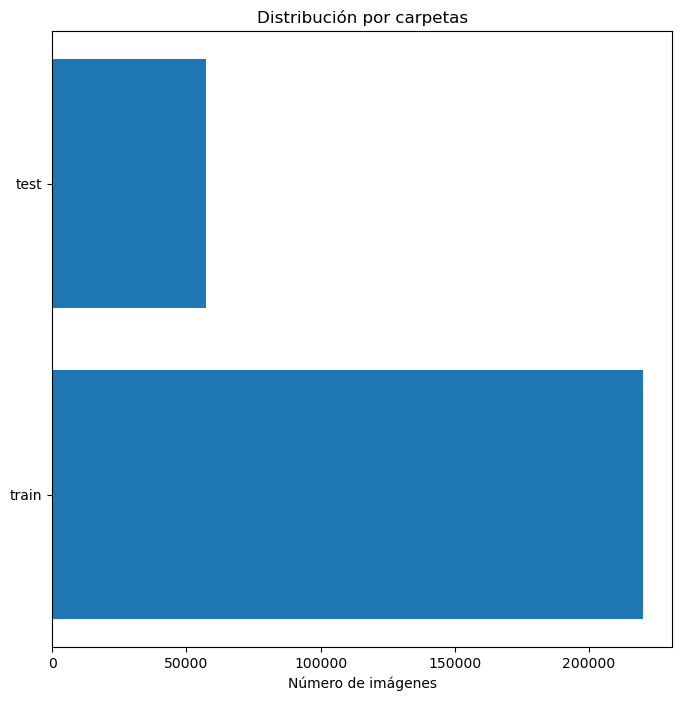

In [4]:
# Crea un Path object para el directorio de entrenamiento
paths_train_dataset = list(Path(train_data_path).rglob('*.tif'))
paths_test_dataset = list(Path(test_data_path).rglob('*.tif'))

# Combinamos ambos paths para conseguir el conteo total
paths_dataset = paths_train_dataset + paths_test_dataset

dict_dataset = defaultdict(list)

# Agrupa las imágenes por su carpeta (train o test)
for p in paths_dataset:
    dict_dataset[p.parent.name].append(str(p))

# Imprime la cantidad y la proporción de imágenes por carpeta
for k in dict_dataset.keys():
    print(f'La carpeta {k} tiene {len(dict_dataset[k])} elementos con proporción {len(dict_dataset[k])/len(paths_dataset):.2f}')

# Configura los parámetros de la figura para matplotlib
plt.rcParams["figure.figsize"] = (8, 8)

# Crea el gráfico de barras horizontal
plt.barh(y=list(dict_dataset.keys()), width=[len(dict_dataset[k]) for k in dict_dataset.keys()])
plt.title('Distribución por carpetas')
plt.xlabel('Número de imágenes')
plt.show()

La misma comprobación pero en un gráfico de sectores.

Los índices por clase son: 
{'test': 1, 'train': 0}


La distribución de los datos por clase es:
{'test': 0.20706854113585338, 'train': 0.7929314588641466}


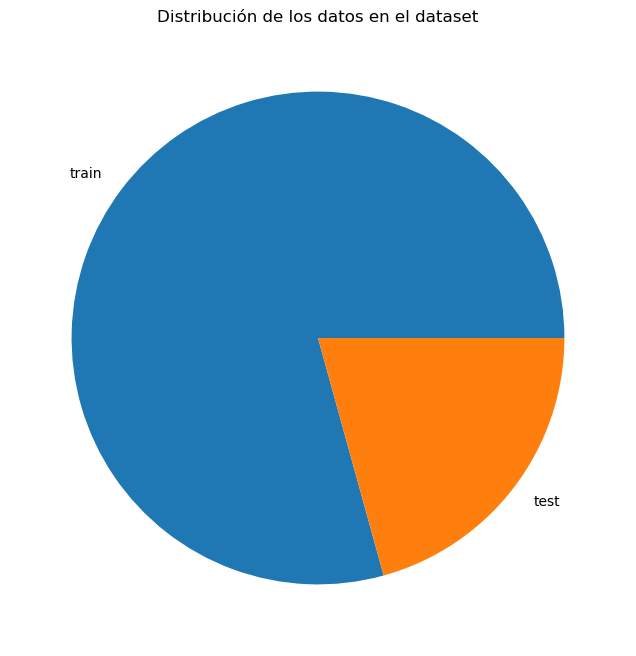

In [5]:
names_to_index = {k: i for i, k in enumerate(dict_dataset.keys())}
names_proportion = {k: len(dict_dataset[k])/len(paths_dataset) for k in dict_dataset.keys()}
print('Los índices por clase son: ')
pprint(names_to_index)
print('\n')
print('La distribución de los datos por clase es:')
pprint(names_proportion)

plt.pie(names_proportion.values(), labels=names_proportion.keys())
plt.title('Distribución de los datos en el dataset')
plt.show()

### 1.3 Visualización de los datos
Comprobamos que los datos son accesibles y que los podemos mostrar.

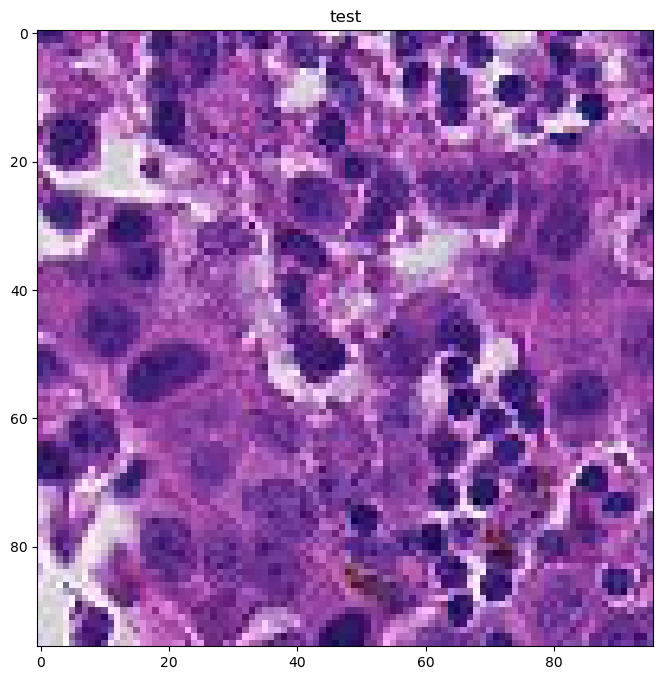

In [6]:
sample_path = random.choice(paths_dataset)

plt.imshow(cv2.imread(str(sample_path))[..., ::-1])
plt.title(sample_path.parent.name)
plt.show()

### 1.4 Formateo de las imágenes
Dado que las imágenes se encuentran en un formato .tif y para poder procesarlas necesitaremos un formato que esté aceptado por Tensorflow, las transformaremos a imágenes .png

In [7]:
# Define la ruta de origen y destino
src_path = pathlib.Path('histopathologic-cancer-detection/train')
def convert_image(src_path):
    dest_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

    # Crea el directorio de destino si no existe
    dest_path.mkdir(parents=True, exist_ok=True)

    # Convierte cada archivo .tif a .png
    for tif_image_path in src_path.glob('*.tif'):
        # Cargar la imagen .tif
        image = Image.open(tif_image_path)
        # Definir el nombre de archivo de destino con la extensión .png
        dest_image_path = dest_path / (tif_image_path.stem + '.png')
        # Guardar la imagen en formato .png
        image.save(dest_image_path, 'PNG')

# Ejecutar solo una vez
# convert_image(src_path)

Haremos lo mismo para test.

In [8]:
# Define la ruta de origen y destino
test_path = pathlib.Path('histopathologic-cancer-detection/test')

def convert_image_test(src_path):
    dest_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

    # Crea el directorio de destino si no existe
    dest_path.mkdir(parents=True, exist_ok=True)

    # Convierte cada archivo .tif a .png
    for tif_image_path in src_path.glob('*.tif'):
        # Cargar la imagen .tif
        image = Image.open(tif_image_path)
        # Definir el nombre de archivo de destino con la extensión .png
        dest_image_path = dest_path / (tif_image_path.stem + '.png')
        # Guardar la imagen en formato .png
        image.save(dest_image_path, 'PNG')

# Ejecutar solo una vez
# convert_image_test(test_path)

Comprobamos si existen imágenes en el nuevo directorio de train.

In [11]:
# TRAIN
train_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(train_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {train_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {train_path}.")

# Crea un dataset a partir de los archivos de imagen
train_dataset = tf.data.Dataset.list_files(str(train_path/'*.png'), shuffle=True)

print(train_dataset)

Se encontraron 220025 imágenes en histopathologic-cancer-detection\train_converted.
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


Comprobamos si existen imágenes en el nuevo directorio de test.

In [10]:
# TEST
test_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(test_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {test_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {test_path}.")

# Crea un dataset a partir de los archivos de imagen
test_dataset = tf.data.Dataset.list_files(str(test_path/'*.png'), shuffle=True)

print(test_dataset)


Se encontraron 57458 imágenes en histopathologic-cancer-detection\test_converted.
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


### 1.5 Dataframe
Este proceso fue necesario llevarlo a cabo mediante etapas ya que el rendimiento del PC sobre el que se realizó el proceso no permitía cargar todos los archivos de imagen de una única vez.   
   
Creación del dataframe de train.

In [25]:
# Rutas a los directorios y archivos
train_dir = 'histopathologic-cancer-detection/train_converted'
train_labels_csv = 'histopathologic-cancer-detection/train_labels.csv'

# Cargar las etiquetas
labels_df = pd.read_csv(train_labels_csv)
labels_df['id'] = labels_df['id'].apply(lambda x: x + '.png')  # Asegurarte de que los IDs tienen la extensión .png

# Crear un generador de imágenes que también realiza la normalización de las mismas
datagen = ImageDataGenerator(rescale=1./255)

# Este generador carga las imágenes directamente del disco en lotes, por lo que no es necesario cargar todas las imágenes en la memoria a la vez
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col='id',  # Nombre del archivo de la imagen
    y_col='label',  # Columna con las etiquetas
    class_mode='raw',  # Tipo de problema de clasificación (binary para 0 o 1)
    target_size=(224, 224),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,  # Tamaño de los lotes de datos
    shuffle=True  # Mezclar los datos de manera aleatoria
)



Found 220025 validated image filenames.


Respetimos el porceso para test.

In [26]:
test_path = 'histopathologic-cancer-detection/test_converted'
validation_labels = pd.read_csv('histopathologic-cancer-detection/validation_labels.csv')

# Cargar las etiquetas de validación
validation_labels['id'] = validation_labels['id'].apply(lambda x: x + '.png')  # Asegurarte de que los IDs tienen la extensión .png

# Crear un generador de imágenes que también realiza la normalización de las mismas para validación
datagen_validation = ImageDataGenerator(rescale=1./255)

# Este generador carga las imágenes de validación directamente del disco en lotes
validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_labels,
    directory=test_path,
    x_col='id',  # Nombre del archivo de la imagen
    y_col='label',  # Columna con las etiquetas
    class_mode='raw',  # Uso de 'raw' para etiquetas numéricas
    target_size=(224, 224),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,  # Tamaño de los lotes de datos
    shuffle=True  # Mezclar los datos de manera aleatoria
)

Found 57458 validated image filenames.


A continuación visualizaremos algunos datos con la finalidad de verificar como se ven las imágenes del conjunto de datos y si las transformaciones están funcionando como se esperaba.

Images shape: (32, 224, 224, 3)
Labels shape: (32,)


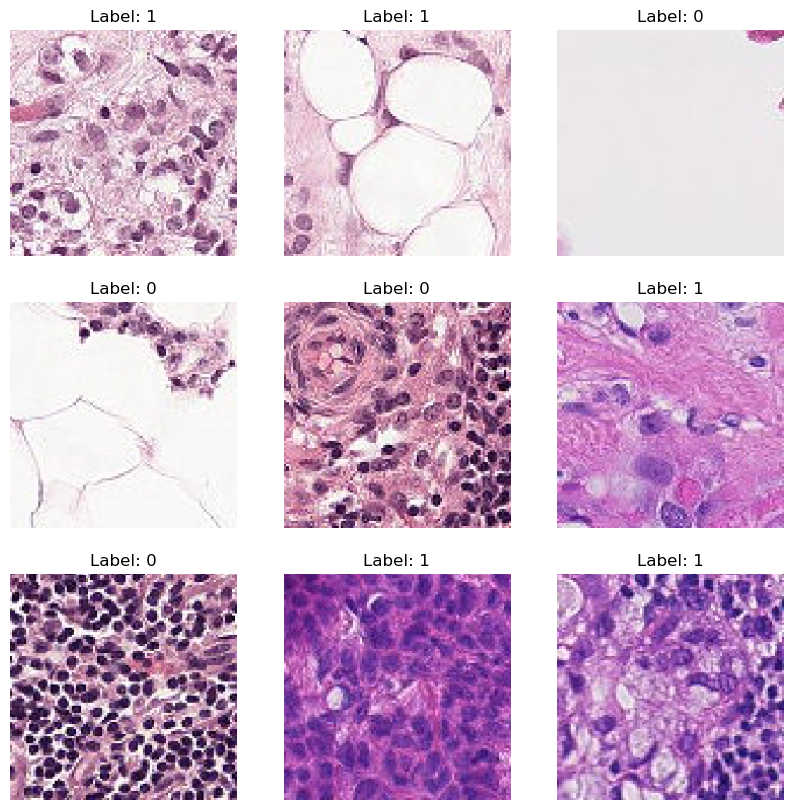

In [27]:
# Configuración ansiosa activada para depuración (si necesario)
tf.config.run_functions_eagerly(True)

# Define una figura con un tamaño específico
plt.figure(figsize=(10, 10))

# Toma un lote del dataset
images, labels = train_generator.next()  # Obtiene un lote directamente
print("Images shape:", images.shape)  # Imprime la forma del tensor de imágenes
print("Labels shape:", labels.shape)  # Imprime la forma del tensor de etiquetas

# Determina el número de imágenes a visualizar
num_images = images.shape[0]
num_subplots = min(num_images, 9)  # Limita a mostrar máximo 9 imágenes

for i in range(num_subplots):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]  # Las imágenes ya están en formato adecuado para visualización
    plt.imshow(img)
    
    # Las etiquetas ya están en formato correcto dado que class_mode='raw' las proporciona como numéricas
    label = labels[i]  # Directamente mostrar la etiqueta asociada

    plt.title(f"Label: {label}")
    plt.axis("off")

plt.show()

## 2. Modelo de Deep Vision

El siguiente paso será la creación del modelo de Deep Vision. En este proceso tendremos que establecer los parámetros con los que queremos entrenar a la red, escoger el modelo a usar y entrenarlo.   

### 2.1 Establecemos los parámetros

A continuación estableceremos los parámetros con los que queremos entrenar a la red, escoger el modelo a usar y entrenarlo. Estos parámetros serán:
- **batch_size**: Define el número de muestras que se procesan antes de que los pesos del modelo cambien.
- **monitor**: Especifica la métrica que se utilizará para monitorizar el rendimiento del modelo durante el entrenamiento.
- **learning_rate**: Define el tamaño del paso que se utiliza para actualizar los pesos del modelo en cada iteración del entrenamiento.
- **epochs**: Es el número total de veces que el conjunto de entrenamiento completo se pasa a través del modelo.
- **early_stopping_patience**: Define cuántas épocas sin mejora en la métrica monitorizada (val_loss) deben transcurrir antes de detener el entrenamiento de manera anticipada.
- **train_backbone**: Determina si las capas base del modelo preentrenado deben ser entrenables o no.
- **version**: Parámetro personalizado, utilizado para versionar modelos y resultados.
- **plateau_factor**: Factor por el cual se reducirá el learning_rate cuando se detecte un estancamiento en la mejora de la métrica monitorizada.
- **plateau_patience**: Número de épocas que deben pasar sin mejora antes de reducir el learning_rate.

Configuración del modelo:
- **input_shape**: Define las dimensiones de las imágenes de entrada al modelo. En este caso, cada imagen tiene un tamaño de 224x224 píxeles con 3 canales de color (RGB).
- **model_name**: Especifica el modelo base que se utilizará. 

In [19]:
# Params 
# Train 
batch_size = 8
monitor = 'val_loss'
learning_rate = 1e-4
epochs = 50
early_stopping_patience = 4
train_backbone = True
version = 0
plateau_factor = 0.5
plateau_patience = 2

# Model 
input_shape = (224, 224, 3)
model_name = 'resnet50'

### 2.2 Modelo 
Mediante el siguiente código seleccionaremos el modelo a utilizar. En este caso será ResNet50V2 ya que se trata de un modelo conocido por su capacidad para manejar eficazmente el problema de desvanecimiento de gradientes y por su buen rendimiento en tareas complejas de clasificación de imágenes.

In [20]:
def get_model(model_name: str, input_shape: tuple, train_backbone: bool):
    inputs = keras.Input(shape=input_shape)
    data_augmentation = keras.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomRotation((-1, 1), fill_mode='reflect', interpolation='nearest'),
        keras.layers.experimental.preprocessing.RandomZoom(width_factor=(0, 0.2), height_factor=(0, 0.2), interpolation='nearest'),
    ])
    x = data_augmentation(inputs)
    
    # Define un diccionario para facilitar la adición de nuevos modelos
    base_models = {
        'mobilenetv2': keras.applications.MobileNetV2,
        'resnet50': keras.applications.ResNet50V2,
    }

    # Preprocesamiento y selección del modelo base según el nombre del modelo
    if model_name in base_models:
        preprocess_input = getattr(keras.applications, model_name).preprocess_input
        x = preprocess_input(x)
        base_model = base_models[model_name](
            include_top=False,
            weights="imagenet",
            input_tensor=x,
            input_shape=input_shape,
        )
    else:
        raise ValueError(f"Modelo '{model_name}' no reconocido. Elija entre: {list(base_models.keys())}")
    
    base_model.trainable = train_backbone
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(x.shape[-1] // 2, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x) 
    x = keras.layers.Dense(x.shape[-1] // 2, activation='relu')(x) 
    predictions = keras.layers.Dense(1, activation='sigmoid')(x) 
    model = keras.Model(inputs=inputs, outputs=predictions)

    return model

# Crea el modelo
model = get_model(model_name, input_shape, train_backbone)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 224, 224, 3)          0         ['sequential[0][0]']          
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)          0         ['tf.__operators__.getit

#### 2.2.1 Técnica de aumento de datos
Esta técnica ayudan a mejorar la generalización del modelo al introducir variabilidad en el conjunto de datos de entrenamiento, lo que permite que el modelo aprenda a reconocer patrones importantes en condiciones variadas y evita que se ajuste demasiado a los datos específicos de entrenamiento (overfitting).
- **RandomFlip("horizontal_and_vertical")**: Esta capa aplica un volteo aleatorio a las imágenes tanto horizontal como verticalmente. Al hacer esto, el modelo puede aprender a reconocer objetos sin importar su orientación en la imagen.
- **RandomRotation((-1, 1), fill_mode='reflect', interpolation='nearest')**: Rota las imágenes un ángulo aleatorio dentro del rango especificado (en este caso, de -360 a 360 grados, ya que -1 y 1 se interpretan como fracciones de una vuelta completa en círculo). fill_mode='reflect' indica que los píxeles faltantes a causa de la rotación serán rellenados reflejando los píxeles en el borde de la imagen. interpolation='nearest' se refiere a cómo se calculan los valores de los nuevos píxeles que aparecen durante la transformación; en este caso, se asigna el valor del píxel más cercano.
- **RandomZoom(width_factor=(0, 0.2), height_factor=(0, 0.2), interpolation='nearest')**: Aplica un zoom aleatorio a las imágenes. Los factores de zoom para la anchura y la altura se establecen entre 0 (sin cambio) y 0.2 (un aumento de hasta el 20%). Al igual que con la rotación, interpolation='nearest' se usa para determinar cómo llenar los nuevos píxeles.

In [21]:
data_augmentation = keras.Sequential(
[
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation((-1, 1), fill_mode='reflect', interpolation='nearest'),
    keras.layers.experimental.preprocessing.RandomZoom(width_factor=(0, 0.2), height_factor=(0, 0.2), interpolation='nearest'),
]
)

#### 2.2.2 Callbacks
Las callbacks permiten realizar acciones específicas en diferentes etapas del entrenamiento del modelo. Cada callback que has mencionado tiene un propósito particular que puede ayudar a mejorar el rendimiento del modelo, ahorrar recursos, o proporcionar información adicional sobre el proceso de entrenamiento.
- **ModelCheckpoint**: Este callback guarda automáticamente el modelo o los pesos del modelo en un archivo, en ciertos intervalos, lo que te permite recuperar y usar el modelo sin tener que reentrenarlo.
    - **save_best_only=True**: Indica que el modelo se guardará solo cuando su desempeño en la métrica monitorizada sea el mejor hasta el momento.
    - **f'weights/{model_name}/version_{version}'**: La ruta especifica dónde se guardarán los archivos del modelo, incluyendo detalles como el nombre del modelo y la versión, lo que facilita la organización y el acceso a diferentes versiones o configuraciones de entrenamiento.
- **EarlyStopping**: Detiene el entrenamiento cuando una métrica monitorizada ha dejado de mejorar, lo cual ayuda a prevenir el sobreajuste y a ahorrar tiempo y recursos si el entrenamiento ya no está siendo productivo.
    - **patience=early_stopping_patience**: Configura cuántas épocas deben pasar sin mejora antes de detener definitivamente el entrenamiento. Esto proporciona un margen para confirmar que el rendimiento realmente ha dejado de mejorar y no es solo una fluctuación en los datos.
- **ReduceLROnPlateau**: Reduce la tasa de aprendizaje (learning rate) cuando una métrica monitorizada ha dejado de mejorar.
    - **factor=plateau_factor**: Especifica el factor de reducción de la tasa de aprendizaje. En este caso, se establece en 0.5, lo que significa que la tasa de aprendizaje se reducirá en un 50% cada vez que la métrica monitorizada no mejore.
    - **patience=plateau_patience**:  Especifica cuántas épocas sin mejora deben pasar antes de reducir la tasa de aprendizaje, permitiendo algunas fluctuaciones antes de hacer un ajuste.
- **TensorBoard**: Proporciona una manera de visualizar diferentes métricas de entrenamiento y validación en tiempo real, usando una interfaz gráfica en el navegador.
    - **log_dir=f'weights/{model_name}/version_{version}'**: Establece el directorio donde se guardarán los logs de TensorBoard, lo que permite un fácil seguimiento y comparación de diferentes experimentos o versiones de entrenamiento.


In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(f'weights/{model_name}/version_{version}', save_best_only=True, monitor=monitor),
    keras.callbacks.EarlyStopping(monitor=monitor, patience=early_stopping_patience, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=plateau_factor, patience=plateau_patience, mode='auto'),
    keras.callbacks.TensorBoard(log_dir=f'weights/{model_name}/version_{version}')
]

#### 2.2.3 Compilación del modelo
El siguiente paso será compilar el modelo, para ello utilizaremos el optimizador de Adam que es uno de los optimizadores más comunes y efectivos en entrenamientos de redes neuronales, especialmente conocido por manejar bien las tasas de aprendizaje adaptativas para diferentes parámetros. Y detallaremos valores como:

- **loss='binary_crossentropy'**: Esta función mide el rendimiento del modelo cuantificando la diferencia entre las etiquetas reales y las predicciones, ideal para situaciones donde las etiquetas son 0 o 1.
- **metrics**: Estas son las medidas que utilizas para juzgar el rendimiento del modelo. Incluyen:
    - **Precisión**: Proporción de identificaciones positivas que fueron realmente correctas.
    - **Recuerdo (Recall)**: Proporción de casos positivos reales que fueron identificados correctamente.
    - **Exactitud Binaria (BinaryAccuracy)**: Mide la frecuencia con la que las predicciones del modelo coinciden con las etiquetas binarias.

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.BinaryAccuracy() 
    ]
)

#### 2.2.4 Entrenamiento del modelo
A continuación habrá que entrenar el modelo, para ello será necesario establecer unos valores a dicho entrenamiento:
- **model.fit()**: Este método es donde ajustas los pesos de tu modelo utilizando tus datos de entrenamiento.
- **train_generator**: Es el generador que alimenta datos al modelo en lotes, permitiendo el uso eficiente de memoria y posiblemente incorporando más aumentos de datos en tiempo real.
- **epochs**: Número total de ciclos completos a través del conjunto de entrenamiento completo que el modelo debería ejecutar durante el entrenamiento.
- **steps_per_epoch**: Total de número de pasos antes de que se declare una época terminada y comience la siguiente época. Normalmente, es el número de muestras dividido por el tamaño del lote.
- **validation_data**: Datos contra los cuales evaluarás el modelo al final de cada época. 
- **validation_steps**: Define cuántos lotes de muestras del conjunto de validación serán evaluados.
- **verbose=1**: Controla la cantidad de salida de información que se muestra durante el entrenamiento; 1 significa que mostrará una barra de progreso.
- **callbacks**: Lista de callbacks que se aplicarán durante el entrenamiento. 

In [28]:
# Entrenamos el modelo
H = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=callbacks
)

d:\anaconda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50

6876/6876 [==============================] - ETA: 0s - loss: 0.2482 - precision: 0.8935 - recall: 0.8578 - binary_accuracy: 0.9010INFO:tensorflow:Assets written to: weights/resnet50\version_0\assets


INFO:tensorflow:Assets written to: weights/resnet50\version_0\assets


6876/6876 [==============================] - 59314s 9s/step - loss: 0.2482 - precision: 0.8935 - recall: 0.8578 - binary_accuracy: 0.9010 - val_loss: 6.2368e-33 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/50
6876/6876 [==============================] - 59299s 9s/step - loss: 0.1793 - precision: 0.9303 - recall: 0.9021 - binary_accuracy: 0.9330 - val_loss: 0.2633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/50
4565/6876 [==================>...........] - ETA: 9:54:11 - loss: 0.1608 - precision: 0.9397 - recall: 0.9120 - binary_accuracy: 0.9408

#### 2.2.5 Gáfica de losses
Permite visualizar la evolución de la pérdida de entrenamiento y la pérdida de validación a lo largo de las épocas durante el entrenamiento de tu modelo.

In [ ]:
# Gráficas losses
epochs_trained = len(H.history['loss'])
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs_trained), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, epochs_trained), H.history['val_loss'], label='val_loss')

plt.title(f'Training and Val Loss {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'weights/{model_name}/version_{version}/losses.png')
plt.show()

#### 2.2.6 Gráfica de precisión y recall
Permite visualizar cómo evolucionan las métricas de precisión, recall y exactitud a lo largo de las épocas durante el entrenamiento y la validación de tu modelo.

In [ ]:
# Gráficas precision recall
plt.style.use('ggplot')
plt.figure()

plt.plot(np.arange(0, epochs_trained), H.history['precision'], label='train_precision')
plt.plot(np.arange(0, epochs_trained), H.history['recall'], label='train_recall')
plt.plot(np.arange(0, epochs_trained), H.history['categorical_accuracy'], label='train_categorical_accuracy')

plt.plot(np.arange(0, epochs_trained), H.history['val_precision'], label='val_precision')
plt.plot(np.arange(0, epochs_trained), H.history['val_recall'], label='val_recall')
plt.plot(np.arange(0, epochs_trained), H.history['val_categorical_accuracy'], label='val_categorical_accuracy')

plt.title(f'Training and val Accuracy/Precision/Recall {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Precision/Recall')
plt.legend()
plt.savefig(f'weights/{model_name}/version_{version}/metrics.png')
plt.show()

#### 2.2.7 Inferencia y evaluación
Por último tendremos que ejecutar inferencias en un conjunto de datos de prueba y calcular métricas de clasificación para evaluar el rendimiento del modelo.

In [ ]:
# Asegura modelo esté limpio antes de cargar uno nuevo
if 'model' in locals():
    del model
    tf.keras.backend.clear_session()

print('Loading model from checkpoint ...')
model_path = f'weights/{model_name}/version_{version}'
model = tf.keras.models.load_model(model_path)
print('Model loaded!')

# Preparación para la inferencia en el conjunto de prueba
preds = []
targets = []

print('Running inference on test data...')
for imgs, labels in tqdm(validation_generator):
    # Realiza la predicción para el batch actual
    batch_preds = model.predict(imgs)
    # Almacena las predicciones como clases predichas más probables
    preds.extend(tf.argmax(batch_preds, axis=1).numpy())
    # Directamente agregar las etiquetas numéricas
    targets.extend(labels)

# Generar y visualizar las métricas de clasificación
print('Calculating classification metrics...')
report = classification_report(targets, preds,  target_names=['Negativo', 'Positivo']) 

# Opcionalmente, guardar el informe de clasificación
with open(f'weights/{model_name}/version_{version}/classification_report.txt', 'w') as f:
    f.write(report)
